In [17]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [18]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [19]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [20]:
# sub number
sub_num = 1

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 3s 26ms/step - loss: 0.6756 - accuracy: 0.7056 - val_loss: 0.6585 - val_accuracy: 0.7367
Epoch 2/200
97/99 [============================>.] - ETA: 0s - loss: 0.6422 - accuracy: 0.7535
Epoch 00002: val_loss improved from inf to 0.63288, saving model to best_model_2.h5
99/99 [==============================] - 2s 24ms/step - loss: 0.6417 - accuracy: 0.7544 - val_loss: 0.6329 - val_accuracy: 0.7367
Epoch 3/200
97/99 [============================>.] - ETA: 0s - loss: 0.6160 - accuracy: 0.7552
Epoch 00003: val_loss improved from 0.63288 to 0.61402, saving model to best_model_2.h5
99/99 [==============================] - 2s 24ms/step - loss: 0.6162 - accuracy: 0.7544 - val_loss: 0.6140 - val_accuracy: 0.7367
Epoch 4/200
97/99 [============================>.] - ETA: 0s - loss: 0.5987 - accuracy: 0.7526
Epoch 00004: val_loss improved from 0.61402 to 0.60114, saving model to best_model_2.h5
99/99 [==============================] - 2s 24ms/step

Epoch 28/200
97/99 [============================>.] - ETA: 0s - loss: 0.5445 - accuracy: 0.7552
Epoch 00028: val_loss improved from 0.55577 to 0.55439, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.5435 - accuracy: 0.7560 - val_loss: 0.5544 - val_accuracy: 0.7443
Epoch 29/200
97/99 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.7542
Epoch 00029: val_loss improved from 0.55439 to 0.55240, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.5421 - accuracy: 0.7563 - val_loss: 0.5524 - val_accuracy: 0.7452
Epoch 30/200
97/99 [============================>.] - ETA: 0s - loss: 0.5406 - accuracy: 0.7552
Epoch 00030: val_loss improved from 0.55240 to 0.55002, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.5399 - accuracy: 0.7560 - val_loss: 0.5500 - val_accuracy: 0.7443
Epoch 31/200
97/99 [============================>.] - ETA:

97/99 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.9037
Epoch 00054: val_loss did not improve from 0.28140
99/99 [==============================] - 2s 25ms/step - loss: 0.2653 - accuracy: 0.9046 - val_loss: 0.2882 - val_accuracy: 0.8698
Epoch 55/200
97/99 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9120
Epoch 00055: val_loss improved from 0.28140 to 0.27691, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.2531 - accuracy: 0.9113 - val_loss: 0.2769 - val_accuracy: 0.8812
Epoch 56/200
97/99 [============================>.] - ETA: 0s - loss: 0.2381 - accuracy: 0.9182
Epoch 00056: val_loss improved from 0.27691 to 0.23233, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.2375 - accuracy: 0.9179 - val_loss: 0.2323 - val_accuracy: 0.9211
Epoch 57/200
97/99 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9265
Epoch 00057:

Epoch 82/200
97/99 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9520
Epoch 00082: val_loss did not improve from 0.15532
99/99 [==============================] - 2s 24ms/step - loss: 0.1490 - accuracy: 0.9518 - val_loss: 0.1825 - val_accuracy: 0.9287
Epoch 83/200
97/99 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9465
Epoch 00083: val_loss improved from 0.15532 to 0.14411, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.1573 - accuracy: 0.9461 - val_loss: 0.1441 - val_accuracy: 0.9601
Epoch 84/200
97/99 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9475
Epoch 00084: val_loss improved from 0.14411 to 0.14369, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.1496 - accuracy: 0.9474 - val_loss: 0.1437 - val_accuracy: 0.9563
Epoch 85/200
97/99 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9475

Epoch 111/200
97/99 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9604
Epoch 00111: val_loss did not improve from 0.12293
99/99 [==============================] - 2s 25ms/step - loss: 0.1145 - accuracy: 0.9598 - val_loss: 0.1282 - val_accuracy: 0.9572
Epoch 112/200
97/99 [============================>.] - ETA: 0s - loss: 0.1179 - accuracy: 0.9588
Epoch 00112: val_loss did not improve from 0.12293
99/99 [==============================] - 2s 25ms/step - loss: 0.1177 - accuracy: 0.9591 - val_loss: 0.1582 - val_accuracy: 0.9354
Epoch 113/200
97/99 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.9588
Epoch 00113: val_loss improved from 0.12293 to 0.12034, saving model to best_model_2.h5
99/99 [==============================] - 2s 25ms/step - loss: 0.1172 - accuracy: 0.9585 - val_loss: 0.1203 - val_accuracy: 0.9658
Epoch 114/200
97/99 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9617
Epoch 00114: val_loss did not im

Epoch 140/200
97/99 [============================>.] - ETA: 0s - loss: 0.0943 - accuracy: 0.9671
Epoch 00140: val_loss did not improve from 0.11132
99/99 [==============================] - 3s 29ms/step - loss: 0.0930 - accuracy: 0.9677 - val_loss: 0.1201 - val_accuracy: 0.9496
Epoch 141/200
97/99 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9633
Epoch 00141: val_loss did not improve from 0.11132
99/99 [==============================] - 3s 29ms/step - loss: 0.1026 - accuracy: 0.9626 - val_loss: 0.1985 - val_accuracy: 0.9173
Epoch 142/200
98/99 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9697
Epoch 00142: val_loss did not improve from 0.11132
99/99 [==============================] - 3s 29ms/step - loss: 0.0880 - accuracy: 0.9693 - val_loss: 0.1562 - val_accuracy: 0.9363
Epoch 143/200
98/99 [============================>.] - ETA: 0s - loss: 0.0956 - accuracy: 0.9640
Epoch 00143: val_loss did not improve from 0.11132
99/99 [===========

Epoch 169/200
97/99 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9726
Epoch 00169: val_loss did not improve from 0.10574
99/99 [==============================] - 3s 28ms/step - loss: 0.0820 - accuracy: 0.9724 - val_loss: 0.1174 - val_accuracy: 0.9553
Epoch 170/200
97/99 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9720
Epoch 00170: val_loss did not improve from 0.10574
99/99 [==============================] - 3s 29ms/step - loss: 0.0799 - accuracy: 0.9718 - val_loss: 0.1089 - val_accuracy: 0.9610
Epoch 171/200
98/99 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9713
Epoch 00171: val_loss did not improve from 0.10574
99/99 [==============================] - 3s 29ms/step - loss: 0.0810 - accuracy: 0.9712 - val_loss: 0.1648 - val_accuracy: 0.9344
Epoch 172/200
97/99 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9633
Epoch 00172: val_loss did not improve from 0.10574
99/99 [===========

97/99 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9758
Epoch 00198: val_loss did not improve from 0.09977
99/99 [==============================] - 2s 25ms/step - loss: 0.0647 - accuracy: 0.9756 - val_loss: 0.1174 - val_accuracy: 0.9572
Epoch 199/200
97/99 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9723
Epoch 00199: val_loss did not improve from 0.09977
99/99 [==============================] - 2s 24ms/step - loss: 0.0694 - accuracy: 0.9718 - val_loss: 0.1039 - val_accuracy: 0.9620
Epoch 200/200
97/99 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9710
Epoch 00200: val_loss did not improve from 0.09977
99/99 [==============================] - 2s 24ms/step - loss: 0.0700 - accuracy: 0.9715 - val_loss: 0.1025 - val_accuracy: 0.9639
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(

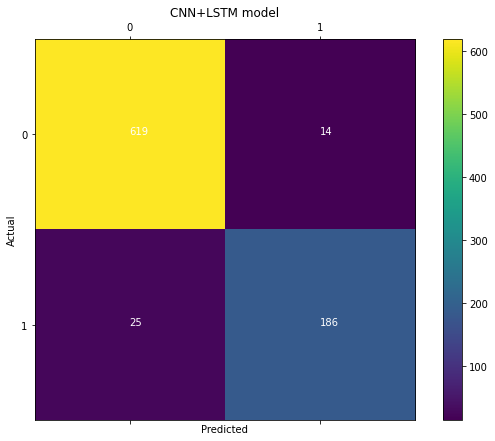

val_loss: 0.09977450221776962
test_loss: 0.13120359182357788
test_acc: 0.9537914395332336
precision: 0.93
recall: 0.8815165876777251
specificity 0.9778830963665087
sensitivity :  0.8815165876777251
far 0.022116903633491312
frr 0.11848341232227488


In [21]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 154, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 190, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 18, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.4476962408598348)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(200)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(174, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(36, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_3)

# Adam
# model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0013958364080478966), metrics = ['accuracy'])
# SGD
model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0003045598974602239, momentum=0.8915087720100587), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)